# Sonification Seizures with Ising Trotter Frequency Modulation

In [1]:
import numpy as np
from scipy.io.wavfile import read, write
from scipy.io import wavfile
from scipy.signal import butter, lfilter, medfilt
import matplotlib.pyplot as plt

### Modified Sonification with a FM driven by the Trotter Ising Model

In [2]:
SAMPLE_RATE   = 44_100
NOTE_DURATION = 0.10          # seconds
FM_RATIO      = 2.0           # modulator = FM_RATIO × carrier

#Ising Dataset output 
modulation_matrix = np.array([
    [0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,
     0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000],
    [0.0002,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,
     0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000],
    [0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0002,
     0.0000,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000],
    [0.0007,0.0012,0.0005,0.0012,0.0010,0.0005,0.0012,0.0012,
     0.0007,0.0005,0.0020,0.0017,0.0010,0.0007,0.0000,0.0007],
    [0.2388,0.2466,0.2554,0.2537,0.2510,0.2588,0.2524,0.2463,
     0.2415,0.2578,0.2610,0.2542,0.2502,0.2615,0.2390,0.2634],
    [0.9082,0.9087,0.9133,0.9048,0.8999,0.9160,0.7048,0.6863,
     0.8918,0.7886,0.7749,0.8479,0.8853,0.9160,0.8870,0.8887],
    [0.9238,0.9255,0.9343,0.9185,0.9006,0.9387,0.7195,0.7029,
     0.8906,0.8010,0.7996,0.8572,0.8999,0.9377,0.9077,0.8948],
    [0.9731,0.9766,0.9888,0.9746,0.9619,0.9614,0.8320,0.8027,
     0.9199,0.8594,0.8452,0.8379,0.9043,0.9512,0.9492,0.9661],
    [0.8267,0.8433,0.8682,0.8706,0.8264,0.7944,0.7849,0.7383,
     0.7727,0.7617,0.7263,0.6521,0.7644,0.7595,0.8035,0.8557]
], dtype=np.float32)

# Transpose → shape (16, 9) so each *row* == one channel’s 9-value sequence
mod_matrix_T = modulation_matrix.T        # (16, 9)

# ── paths for the 16 channels ────────────────────────────────────────────────
file_paths = [
    "./channels_for_sonification/AST1_no_first.txt",
    "./channels_for_sonification/AST2_no_first.txt",
    "./channels_for_sonification/TT1_no_first.txt",
    "./channels_for_sonification/MST1_no_first.txt",
    "./channels_for_sonification/MST2_no_first.txt",
    "./channels_for_sonification/MST3_no_first.txt",
    "./channels_for_sonification/MST4_no_first.txt",
    "./channels_for_sonification/PST1_no_first.txt",
    "./channels_for_sonification/PST2_no_first.txt",
    "./channels_for_sonification/PST3_no_first.txt",
    "./channels_for_sonification/PST4_no_first.txt",
    "./channels_for_sonification/TT2_no_first.txt",
    "./channels_for_sonification/TT3_no_first.txt",
    "./channels_for_sonification/TT4_no_first.txt",
    "./channels_for_sonification/TT5_no_first.txt",
    "./channels_for_sonification/TT6_no_first.txt"
]                                           # 16 paths ↔ 16 matrix columns

def load_time_series(path, step=500):
    t, v = [], []
    with open(path) as f:
        for i, line in enumerate(f):
            if i % step:
                continue
            try:
                tt, vv = map(float, line.split())
                t.append(tt); v.append(vv)
            except ValueError:
                continue
    return np.asarray(t), np.asarray(v)

def fm_note(f_c, I, duration, sample_rate, fm_ratio):
    """Return one FM note of length `duration`."""
    t   = np.linspace(0, duration, int(sample_rate*duration), endpoint=False)
    f_m = f_c * fm_ratio
    return np.sin(2*np.pi*f_c*t + I*np.sin(2*np.pi*f_m*t))

def generate_wave_fm_segmented(pitches, segment_indices,
                               note_duration=NOTE_DURATION,
                               sample_rate=SAMPLE_RATE,
                               fm_ratio=FM_RATIO):
    """
    FM-synth an entire channel where the *first N/9 notes* use segment_indices[0],
    the next N/9 use segment_indices[1], and so on.
    """
    n_notes   = len(pitches)
    seg_size  = max(1, n_notes // 9)          # notes per segment
    waveform  = []

    for n, f_c in enumerate(pitches):
        seg_id = min(8, n // seg_size)        # 0‒8
        I      = segment_indices[seg_id]
        waveform.append(0.5 * fm_note(f_c, I, note_duration,
                                      sample_rate, fm_ratio))

    return np.concatenate(waveform, dtype=np.float32)

def sonify_files(paths, mod_T):
    if len(paths) != mod_T.shape[0]:
        raise ValueError("Need exactly 16 paths for 16 channels.")

    waves = []
    for i, path in enumerate(paths):
        _, values = load_time_series(path)

        # map to C4–B5
        vals_norm = (values - np.min(values)) / (np.ptp(values) + 1e-12)
        freqs     = 261.63 + vals_norm * (1244.51 - 261.63)

        waves.append(generate_wave_fm_segmented(freqs, mod_T[i]))

    L     = max(len(w) for w in waves)
    mix   = np.sum([np.pad(w, (0, L-len(w))) for w in waves], axis=0)
    mix  /= np.max(np.abs(mix)) + 1e-12
    return mix

# ── run ──────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    combined = sonify_files(file_paths, mod_matrix_T)
    write("fm_sonification.wav",
          SAMPLE_RATE,
          (combined * 32767).astype(np.int16))


### Cleanup Generated sound - just as the original sonification

In [3]:
def lowpass_filter(data, cutoff=2000, sample_rate=44100, order=5):
    """Apply a low-pass Butterworth filter."""
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)

def remove_clicks(audio_data, kernel_size=7):
    """Apply a median filter to remove sharp transient clicks."""
    return medfilt(audio_data, kernel_size=kernel_size)

def process_audio(input_path, output_path, cutoff = 2000, kernel_size = 10):
    # Load the WAV file
    sample_rate, data = read(input_file)

    # If stereo, take only one channel
    if data.ndim > 1:
        data = data[:, 0]

    # Normalize if in int16 format
    if data.dtype == np.int16:
        data = data.astype(np.float32) / 32767.0

    # Step 1: Low-pass filter
    filtered = lowpass_filter(data, cutoff=cutoff, sample_rate=sample_rate)

    # Step 2: Click removal via median filtering
    cleaned = remove_clicks(filtered, kernel_size=kernel_size)

    # Normalize output to avoid clipping
    cleaned = cleaned / np.max(np.abs(cleaned))

    # Save the result
    write(output_file, sample_rate, (cleaned * 32767).astype(np.int16))
    
    

In [4]:
input_file = "./fm_sonification.wav"
output_file = "./fm_sonification_filtered_and_declicked.wav"

process_audio(input_file, output_file, cutoff = 2000, kernel_size=7)


### Plot Spectrogram

In [7]:
def plot_spectrogram(title, wav_path):
    """Plot a spectrogram of the given WAV file."""
    sample_rate, data = read(wav_path)
    
    # If stereo, take only one channel
    if data.ndim > 1:
        data = data[:, 0]
    
    plt.figure(figsize=(12, 6))
    plt.specgram(data, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='inferno')
    #plt.title("Spectrogram")
    plt.title(title, fontsize=22)
    plt.xlabel("Time (s)",fontsize=16)
    plt.ylabel("Frequency (Hz)",fontsize=16)
    plt.colorbar(label="Intensity (dB)")
    plt.tight_layout()
    #plt.savefig("/Users/mariamannone/Desktop/new_phd_/sonification_test_epilepsy_/{title}.pdf", format="pdf", bbox_inches="tight")
    plt.savefig(f"{title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

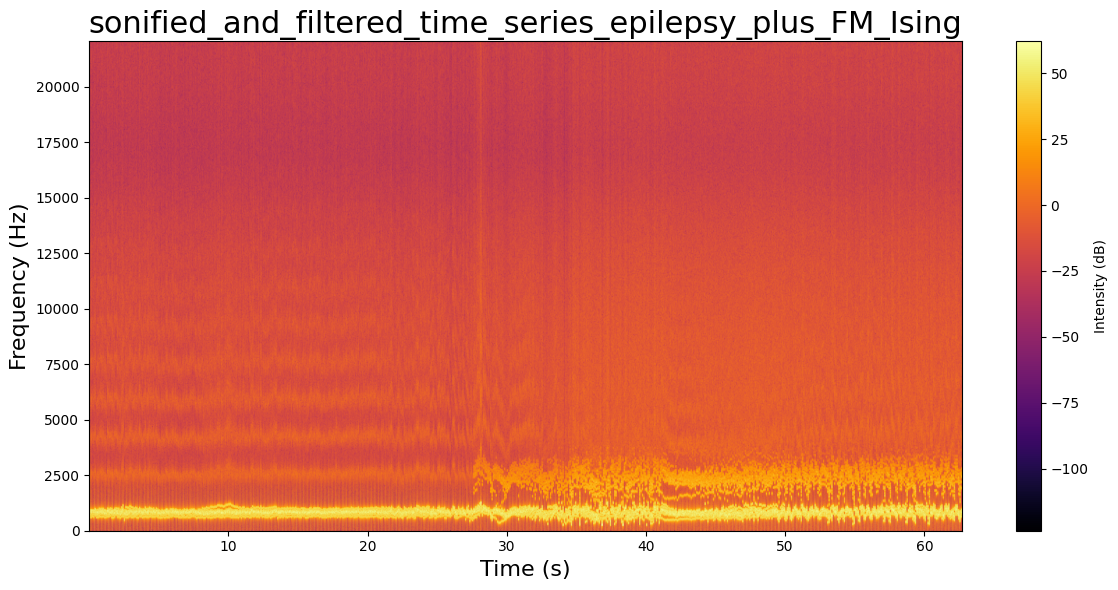

In [9]:
plot_spectrogram("sonified_and_filtered_time_series_epilepsy_plus_FM_Ising", "fm_sonification_filtered_and_declicked.wav")
